# 1. Importing Packages

In [4]:
from qiskit import *
import numpy as np

# 2. Background

## 2.1 Huawei HiQ 

The HHL algorithm broadly has 5 steps( <a herf="https://hiqsimulator.readthedocs.io/en/latest/examples/examples.HHLAlgorithm.html">link</a> ):

<ol>
        <li>Initialization: Initialize the vector b⃗  to be quantum state |b⟩.
        <li>Estimate the eigenvalues of matrix A: Use the phase estimation algorithm to get the value of λ in $e^{2πiλ}$ which is also the eigenstate of matrix A.
        <li>Controlled rotation: Controlled rotation of auxiliary qubit is performed according to the estimated eigenvalues.Then use the approximate value $\frac{\theta}{2r}$ as sin(θ2r), which is the reciprocal of the eigenvalue.
        <li>Reset |q0q1⟩ as |00⟩ using the reverse phase estimation algorithm.
        <li>Measure |q3⟩; If the result is 1, the corresponding quantum state |q2⟩=|x⟩. Then the approximate solution of the equations can be obtained.
</ol>


Given below is how Huawei HiQ has implemented the HHL algorithm. We would be trying to replicate this particular circuit.

<img src="https://hiqsimulator.readthedocs.io/en/latest/_images/HHL.png"></img>

Though here in this particular case they have employed certain workarounds for the underlying assumptions with the algo, it is important to understand these assumptions (to prove that the running time of this alogrithm is actually advantageous than the classical computers):

>We have a effective way of doing Quantum simulation step i.e. The encoding the matrix A to $e^{iA}$ (on which wwe'll will next perform the eigen vecore decomposition to get the eigen vectors of A which wil be used to encode the value of b in terms of these eigen vectors of A)
        
>Another assumption is that we have an effective fast, O(log(N)), algorithm to rotate the $\lambda$ (eigen value). 
        
>Also in this particular case since it's for demonstration purpose, we already know the answer and to get the correct answer, we tune our parameters like $t_0$ and number of qubits in the registers for this particular case.


## 2.2 IBM Qiskit

The IBM on the other hand has taken these assumptions (Note: These algorithms are not generalized i.e. they can't be used for any arbitary matrix): 

> $A = \begin{pmatrix}
    a & b  \\
    b & a  \\
    \end{pmatrix} and |b⟩ = \begin{pmatrix}
                            cos(θ)\\ 
                            sin(θ)\\
                            \end{pmatrix}, a, b, θ ∈ R$.
                            
> a=1, b=-1/3 and t=2 (choosen for this particular a and b)

The complete tutorial can be found <a href="https://qiskit.org/textbook/ch-applications/hhl_tutorial.html#3.-Example:-4-qubit-HHL">here</a>

<img src="https://qiskit.org/textbook/ch-applications/images/hhlcircuit.png"> </img>

In [8]:
t = 2  # This is not optimal; As an exercise, set this to the
       # value that will get the best results. See section 8 for solution.

nqubits = 4  # Total number of qubits
nb = 1  # Number of qubits representing the solution
nl = 2  # Number of qubits representing the eigenvalues

theta = 0  # Angle defining |b>

a = 1  # Matrix diagonal
b = -1/3  # Matrix off-diagonal

# Initialise the quantum and classical registers
qr = QuantumRegister(nqubits)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# State preparation. 
qc.ry(2*theta, qrb[0])

# QPE with e^{iAt}
for qu in qrl:
    qc.h(qu)

qc.u1(a*t, qrl[0])
qc.u1(a*t*2, qrl[1])

qc.u3(b*t, -np.pi/2, np.pi/2, qrb[0])


# Controlled e^{iAt} on \lambda_{1}:
params=b*t

qc.u1(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.u1(3*np.pi/2,qrb[0])

# Controlled e^{2iAt} on \lambda_{2}:
params = b*t*2

qc.u1(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.u1(3*np.pi/2,qrb[0])

# Inverse QFT
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

# Eigenvalue rotation
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4


qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])
qc.measure_all()

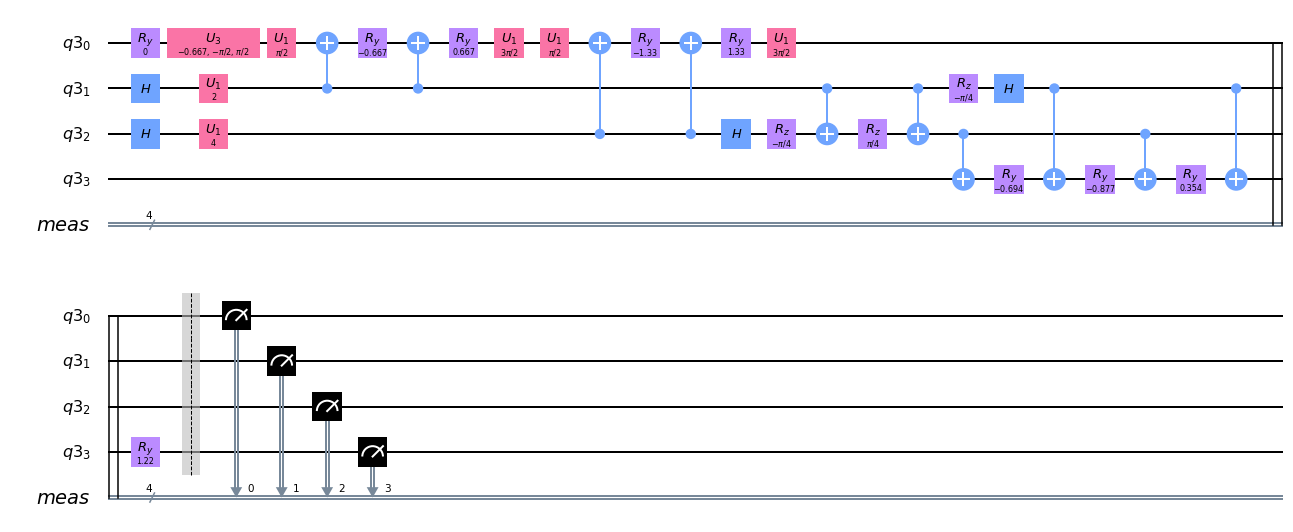

In [9]:
qc.draw('mpl')


In [31]:
backend=Aer.get_backend('statevector_simulator')
result=execute(qc,backend=backend,shots=1024).result()


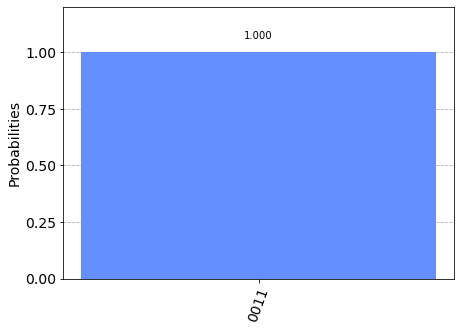

In [32]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(result.get_counts())

In [33]:
print(result.get_statevector())

[ 0.        +0.j          0.        +0.j          0.        +0.j
 -0.36069764+0.93268281j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j        ]
